In [2]:
import xarray as xr
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import sys
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#import cmocean
import glob
import os
import pandas as pd
from scipy.stats import pearsonr

# LOAD DATA

obs_ssdflux_path="/Volumes/Thalassa/ERA5_data/SSDflux_rg/"
obs_curl_path="/Volumes/Thalassa/ORAS5/ORAS5_wind_stress_curl_rg/"
obs_wsm_path="/Volumes/Thalassa/ORAS5/ORAS5_wind_stress_magnitude_rg/"
obs_shdr_path="/Volumes/Thalassa/CORA_SHDR_rg/"

obs_shdr=xr.open_mfdataset(sorted(glob.glob(obs_shdr_path+'*.nc')))
obs_curl=xr.open_mfdataset(sorted(glob.glob(obs_curl_path+'*.nc')))
obs_wsm=xr.open_mfdataset(sorted(glob.glob(obs_wsm_path+'*.nc')))
obs_ssdflux=xr.open_dataset(obs_ssdflux_path+'SSDflux_ERA5_ORAS5.nc')


# --- Compute Climatology (Monthly Means) ---
obs_shdr_clim = obs_shdr.groupby('time.month').mean(dim='time')
obs_curl_clim = obs_curl.groupby('time_counter.month').mean(dim='time_counter')
obs_ssdflux_clim = obs_ssdflux.groupby('time.month').mean(dim='time')
obs_wsm_clim = obs_wsm.groupby('time_counter.month').mean(dim='time_counter')

cmip6_shdr_ens_all=xr.open_dataset("/Volumes/Thalassa/cmip6_clim_ens/shdr.nc")
cmip6_curl_ens_all=xr.open_dataset("/Volumes/Thalassa/cmip6_clim_ens/curl.nc")
cmip6_ssdflux_ens_all=xr.open_dataset("/Volumes/Thalassa/cmip6_clim_ens/ssdflux.nc")
cmip6_wsm_ens_all=xr.open_dataset("/Volumes/Thalassa/cmip6_clim_ens/wsm.nc")

In [3]:
season=[1,2,3,4,5,6,7,8,9,10,11,12]
diff_wsm=cmip6_wsm_ens_all.wsm.sel(month=season).mean('month')-obs_wsm_clim.wsm.sel(month=season).mean('month')
#diff.plot(vmin=-0.04,vmax=0.04)
diff_curl=cmip6_curl_ens_all.curl.sel(month=season).mean('month')-obs_curl_clim.curl.sel(month=season).mean('month')
#diff.plot(vmin=-0.1e-8,vmax=0.1e-8)
diff_Fs=cmip6_ssdflux_ens_all.Fs.sel(month=season).mean('month')-obs_ssdflux_clim.Fs.sel(month=season).mean('month')
#diff.plot(vmin=-0.01e-5,vmax=0.01e-5)
diff_Ft=(cmip6_ssdflux_ens_all.Ft.sel(month=season).mean('month')-obs_ssdflux_clim.Ft.sel(month=season).mean('month'))

#diff=cmip6_ssdflux_ens_all.Frho.median('model').mean('month')-obs_ssdflux_clim.Frho.mean('month')
#diff.plot(vmin=-0.1e-5,vmax=0.1e-5)
diff_b3=cmip6_shdr_ens_all.sel(param='b3').shdr.sel(month=season).mean('month')-obs_shdr_clim.sel(param='b3').shdr.sel(month=season).mean('month')
#diff.plot(vmin=-1e-3,vmax=1e-3)
diff_D1=cmip6_shdr_ens_all.sel(param='D1').shdr.sel(month=season).mean('month')-obs_shdr_clim.sel(param='D1').shdr.sel(month=season).mean('month')
#diff.plot(vmin=-50,vmax=50)
diff_a1=cmip6_shdr_ens_all.sel(param='a1').shdr.sel(month=season).mean('month')-obs_shdr_clim.sel(param='a1').shdr.sel(month=season).mean('month')
diff_a3=cmip6_shdr_ens_all.sel(param='a3').shdr.sel(month=season).mean('month')-obs_shdr_clim.sel(param='a3').shdr.sel(month=season).mean('month')



In [8]:
import numpy as np
import xarray as xr
from scipy.stats import linregress, theilslopes, pearsonr

# Function to compute regression, correlation, and slopes for each grid point
def compute_statistics(D_bias, i_bias):
    # Remove NaNs
    valid_mask = ~np.isnan(D_bias) & ~np.isnan(i_bias)
    if valid_mask.sum() < 2:  # Need at least two valid data points
        return np.nan, np.nan, np.nan, np.nan, np.nan

    D_bias_clean = D_bias[valid_mask]
    i_bias_clean = i_bias[valid_mask]

    # Compute IQR-based outlier filtering
    q1 = np.percentile(i_bias_clean, 25)
    q3 = np.percentile(i_bias_clean, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outlier_mask = (i_bias_clean >= lower_bound) & (i_bias_clean <= upper_bound)
    D_bias_filtered = D_bias_clean[outlier_mask]
    i_bias_filtered = i_bias_clean[outlier_mask]

    if D_bias_filtered.size < 2:  # Need at least two points for regression
        return np.nan, np.nan, np.nan, np.nan, np.nan

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(i_bias_filtered, D_bias_filtered)

    # Compute Theil-Sen slope
    theil_slope, theil_intercept, lower, upper = theilslopes(D_bias_clean, i_bias_clean, 0.95)

    # Compute Pearson correlation coefficient
    r_value_pearson, _ = pearsonr(D_bias_filtered, i_bias_filtered)

    return slope, intercept, theil_slope, theil_intercept, r_value_pearson

# Apply function across all lat/lon points
results = xr.apply_ufunc(
    compute_statistics,
    diff_b3,
    diff_Fs,
    input_core_dims=[["model"], ["model"]],
    output_core_dims=[(), (), (), (), ()],  # Five scalar outputs
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float, float, float, float, float],  # Corresponding to slope, intercept, etc.
)

# Assign names to results
slope, intercept, theil_slope, theil_intercept, r_value_pearson = results

# Now, `slope`, `intercept`, `theil_slope`, `theil_intercept`, and `r_value_pearson` are xarray DataArrays
# with dimensions (lat, lon) containing the regression statistics


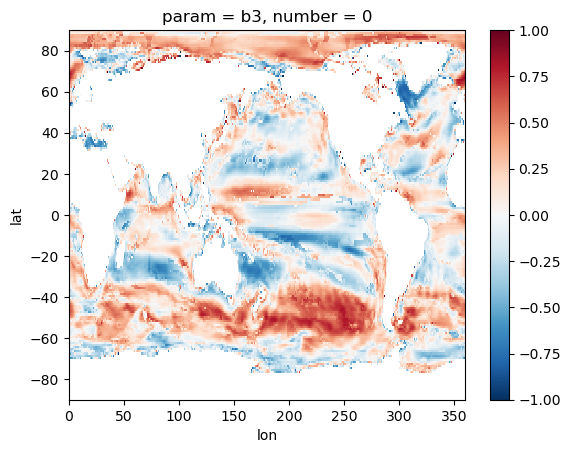

In [9]:
r_value_pearson.plot()

In [7]:
cmip6_mld=cmip6_shdr_ens_all.shdr.sel(param='D1')
cmip6_mld.rename('mld').to_netcdf('/Users/ignasivalles/Oceanography/IEO/projects/cmip6_stratification/data/raw/cmip6_SHDRalgorithm_MLD.nc')



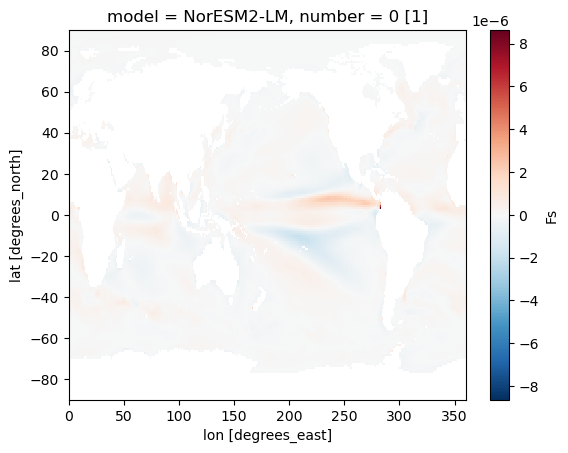

In [24]:
diff_Fs.isel(model=1).plot()